In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, SelectKBest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate", "label"]
df = pd.read_csv('./data/kddcup/kddcup.data_10_percent', header=None, names=col_names)

In [3]:
df.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
494016,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.
494020,0,tcp,http,SF,219,1234,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,35,0.00,0.00,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.


In [4]:
label_enc = LabelEncoder()
df['protocol_type'] = label_enc.fit_transform(df['protocol_type'])
df['service'] = label_enc.fit_transform(df['service'])
df['flag'] = label_enc.fit_transform(df['flag'])
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

In [5]:
X = df.drop('label', axis = 1)
y = df['label']

In [6]:
zero_variance_cols = []
for col in X.columns:
    if len(X[col].unique()) == 1:
        zero_variance_cols.append(col)
X.drop(zero_variance_cols, axis = 1, inplace = True)
print('\nzero variance columns', zero_variance_cols, 'dropped')
print('shape after removing zero variance columns:', df.shape)


zero variance columns ['num_outbound_cmds', 'is_host_login'] dropped
shape after removing zero variance columns: (494021, 42)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
# Function to print classification reports and plot confusion matrix and ROC curve
def print_reports(clf, X_test, y_test, y_pred, classes, title):
    print(title)
    # print classification report
    print(classification_report(y_test, y_pred))
    
    print()
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print()
    
    # plot ROC curve
    roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## Balance dataset

In [9]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [10]:
y_train_res.value_counts()

label
1    277728
0    277728
Name: count, dtype: int64

## Model Training

In [11]:
%%time
sgd_clf = SGDClassifier(max_iter=5000)
sgd_clf.fit(X_train_res, y_train_res)
sgd_pred = sgd_clf.predict(X_test)

CPU times: user 821 ms, sys: 49.2 ms, total: 871 ms
Wall time: 796 ms


SGD Classifier Confusion Matrix
              precision    recall  f1-score   support

           0       0.60      0.82      0.69     29192
           1       0.95      0.86      0.91    119015

    accuracy                           0.85    148207
   macro avg       0.77      0.84      0.80    148207
weighted avg       0.88      0.85      0.86    148207




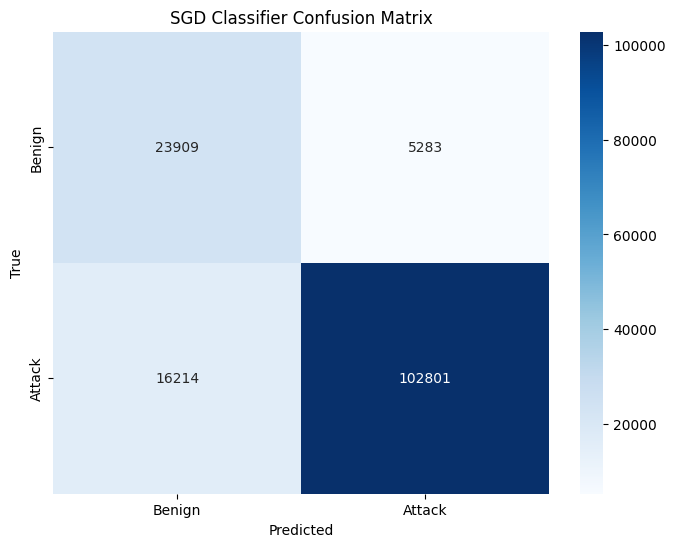

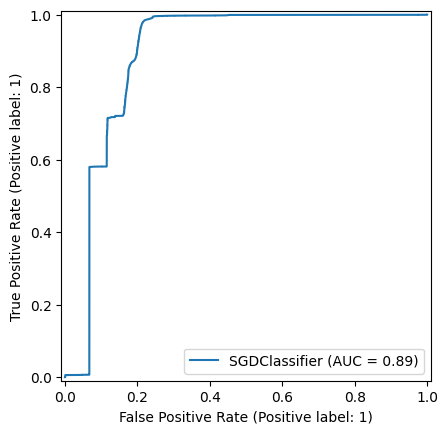

In [12]:
print_reports(sgd_clf, X_test, y_test, sgd_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix')

## Select 15 best features

In [11]:
selector = SelectKBest(k=15)
X_selected = selector.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [12]:
feature_names = X.columns.values[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]
feature_data = zip(feature_names, feature_scores)
selected_features_df = pd.DataFrame(data = feature_data, columns=["Features", "Scores"])
selected_features_df_sorted = selected_features_df.sort_values(["Scores", "Features"], ascending = [False, True])
print("15 best features\n")
print(selected_features_df_sorted)

15 best features

                       Features         Scores
3                     logged_in  850154.317810
4                         count  646838.996509
10               dst_host_count  346586.659196
0                 protocol_type  303038.674112
5                     srv_count  233866.105363
11  dst_host_same_src_port_rate  149069.285979
9            srv_diff_host_rate   75781.513275
8                 same_srv_rate   32210.127821
14     dst_host_srv_serror_rate   27082.903740
6                   serror_rate   27024.027761
13         dst_host_serror_rate   26890.373163
7               srv_serror_rate   26886.528890
12  dst_host_srv_diff_host_rate   21662.570155
2                          flag   12269.263512
1                       service    8722.991373


In [38]:
for feature in feature_names:
    print(f"{feature},")

protocol_type,
service,
flag,
logged_in,
count,
srv_count,
serror_rate,
srv_serror_rate,
same_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,


In [17]:
sgd_clf.fit(X_train_res, y_train_res)
sgd_pred = sgd_clf.predict(X_test)

SGD Classifier Confusion Matrix w/ 15 best features
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29192
           1       1.00      0.98      0.99    119015

    accuracy                           0.98    148207
   macro avg       0.96      0.99      0.97    148207
weighted avg       0.98      0.98      0.98    148207




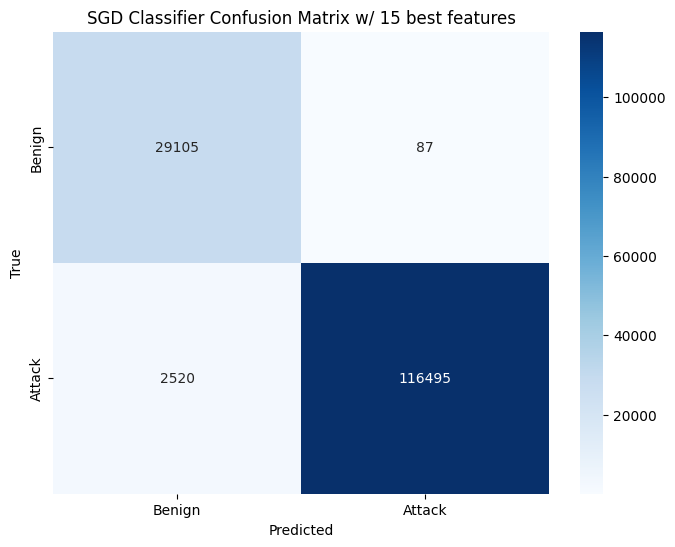

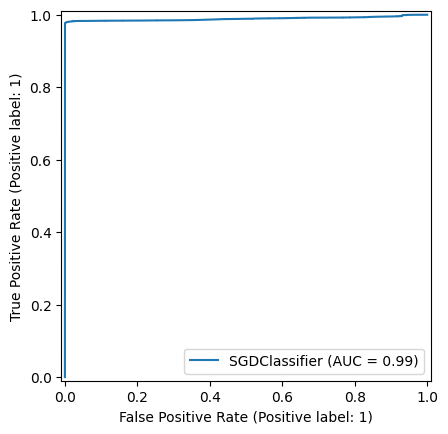

In [18]:
print_reports(sgd_clf, X_test, y_test, sgd_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix w/ 15 best features')

## Hyperparameter tuning

In [14]:
cv = StratifiedKFold(3)

In [14]:
# parameters = {
#     'loss': ['hinge', 'log_loss', 'modified_huber'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'learning_rate': ['optimal', 'adaptive'],
#     'eta0': [0.01, 0.1, 0.0],
#     'epsilon': [0.1, 0.2, 0.5]
# }

## Steps
1. Balance training data
2. Train SGD model
3. Select 15 best features and train (SelectKBest)
4. Use GridSearchCV to select best hyperparameters
5. Finally, train SGD with 15 best features and best hyperparameters
6. Done!

In [15]:
parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    #'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet']
}

In [16]:
sgd_clf2 = SGDClassifier(max_iter=30000)
rs_clf = RandomizedSearchCV(sgd_clf2, parameters, cv=cv, n_jobs=-1, n_iter=6, verbose=5)

In [17]:
rs_clf.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 2/3] END .........loss=log_loss, penalty=l2;, score=0.963 total time=  25.5s
[CV 3/3] END .loss=log_loss, penalty=elasticnet;, score=0.989 total time=  26.1s
[CV 2/3] END ....loss=hinge, penalty=elasticnet;, score=0.987 total time=  26.0s
[CV 3/3] END .........loss=log_loss, penalty=l2;, score=0.956 total time=  26.9s
[CV 2/3] END ............loss=hinge, penalty=l2;, score=0.988 total time=  27.9s
[CV 1/3] END .........loss=log_loss, penalty=l2;, score=0.989 total time=  28.0s
[CV 1/3] END ............loss=hinge, penalty=l2;, score=0.989 total time=  20.2s
[CV 2/3] END ...loss=modified_huber, penalty=l2;, score=0.984 total time=  34.0s
[CV 3/3] END ....loss=hinge, penalty=elasticnet;, score=0.989 total time=  17.5s
[CV 1/3] END ...loss=modified_huber, penalty=l2;, score=0.988 total time=  40.1s
[CV 1/3] END ....loss=hinge, penalty=elasticnet;, score=0.989 total time=  20.9s
[CV 3/3] END ...loss=modified_huber, penalty=l2;,

/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=SGDClassifier(max_iter=30000), n_iter=6, n_jobs=-1,
                   param_distributions={'loss': ['hinge', 'log_loss',
                                                 'modified_huber'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   verbose=5)

[CV 1/3] END .loss=log_loss, penalty=elasticnet;, score=0.968 total time=  24.4s
[CV 1/3] END ...loss=modified_huber, penalty=l1;, score=0.984 total time=35.9min
[CV 3/3] END ............loss=hinge, penalty=l2;, score=0.987 total time=  25.0s
[CV 2/3] END ...loss=modified_huber, penalty=l1;, score=0.984 total time=35.9min
[CV 2/3] END .loss=log_loss, penalty=elasticnet;, score=0.988 total time=  25.2s
[CV 3/3] END ...loss=modified_huber, penalty=l1;, score=0.984 total time=35.9min


In [22]:
rs_clf.best_params_

{'penalty': 'elasticnet', 'loss': 'hinge'}

In [25]:
parameters = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet']
}
rs_clf2 = RandomizedSearchCV(sgd_clf2, parameters, cv=cv, n_jobs=-1, n_iter=12, verbose=5)

In [26]:
rs_clf2.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END alpha=0.01, loss=hinge, penalty=l2;, score=0.986 total time=   3.6s
[CV 2/3] END alpha=0.001, loss=log_loss, penalty=l2;, score=0.986 total time=   7.4s
[CV 1/3] END alpha=0.01, loss=hinge, penalty=l1;, score=0.982 total time=10.9min
[CV 2/3] END alpha=0.01, loss=hinge, penalty=l2;, score=0.988 total time=   3.2s
[CV 1/3] END alpha=0.001, loss=log_loss, penalty=l2;, score=0.988 total time=   7.7s
[CV 2/3] END alpha=0.01, loss=hinge, penalty=l1;, score=0.983 total time= 8.7min
[CV 1/3] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.986 total time=  18.7s
[CV 2/3] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.986 total time=  17.0s
[CV 3/3] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.988 total time=  22.4s
[CV 1/3] END alpha=0.0001, loss=log_loss, penalty=l2;, score=0.988 total time=  27.0s
[CV 2/3] END alpha=0.0001, loss=log_loss, penalty=l2;, score=0.988 total time=  27.3s
[CV 3/3] END alpha=0.000

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=SGDClassifier(max_iter=30000), n_iter=12,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01],
                                        'loss': ['hinge', 'log_loss'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   verbose=5)

[CV 1/3] END alpha=0.0001, loss=hinge, penalty=l1;, score=0.985 total time=30.3min
[CV 1/3] END alpha=0.0001, loss=hinge, penalty=elasticnet;, score=0.987 total time=  24.9s
[CV 2/3] END alpha=0.0001, loss=log_loss, penalty=l1;, score=0.985 total time=31.0min


In [34]:
print(rs_clf2.best_params_)
print(rs_clf2.best_score_)

{'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.0001}
0.9879360381380344


In [32]:
clf = SGDClassifier(max_iter=5000, penalty='elasticnet', loss='hinge', alpha=0.0001)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

SGD Classifier Confusion Matrix w/ 15 best features and hyperparameter tuning
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29192
           1       1.00      0.98      0.99    119015

    accuracy                           0.98    148207
   macro avg       0.96      0.99      0.97    148207
weighted avg       0.98      0.98      0.98    148207




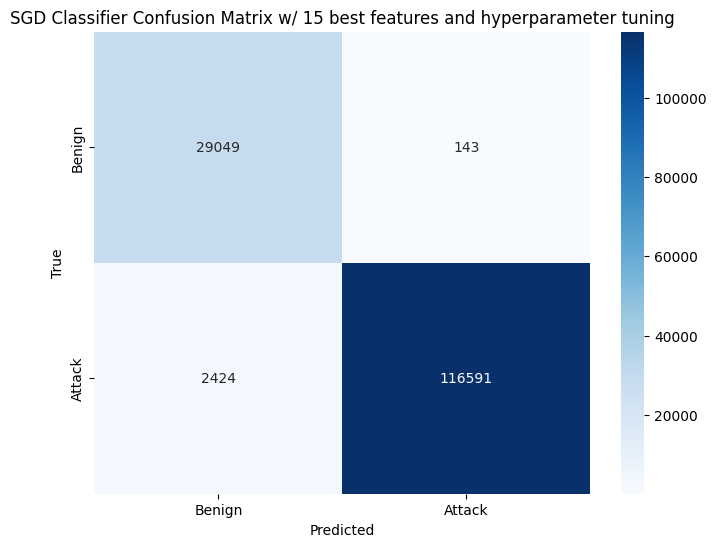

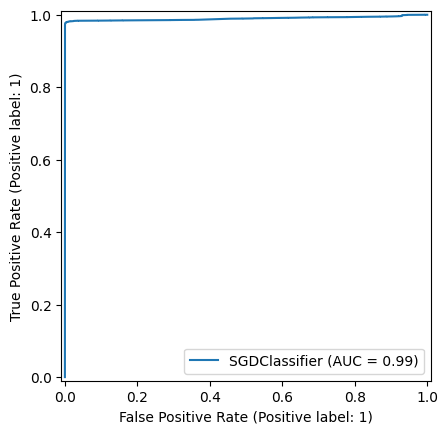

[CV 2/3] END alpha=0.0001, loss=hinge, penalty=elasticnet;, score=0.988 total time=  25.9s
[CV 3/3] END alpha=0.0001, loss=log_loss, penalty=l1;, score=0.983 total time=34.3min


In [33]:
print_reports(clf, X_test, y_test, y_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix w/ 15 best features and hyperparameter tuning')